# Datos del problema

El objetivo de este problema es predecír el gasto energético y el nivel de intesisdad de la actividad de una persona de 75Kg de peso. Para ello disponemos de los siguientes datos con sus respectivas unidades:

* ***Acelereción***: Tendremos las aceleraciones para los distintos ejes (x,y,z) medidos en ***m/s^2***.
* ***Frecuencia Cardiaca***: Pulsacones del corazon por minuto.
* ***Gasto Energético***: El gasto energetico por intervalo de tiempo en ***Kcal/t***.
* ***MET***: medida que permite calcular el consumo de oxígeno, equivalente a ***1MET= 0,0167Kcal/Kg*min***.

Para nuestros caso vamos a tener el siguiente intervalo:
* ***Intensidad baja***: intensidad < 3,75 Kcal/min
* ***Intensidad media***: 3,75 Kcal/min < intensidad < 7,5 Kcal/min
* ***Intensidad baja***: intensidad > 7,5 Kcal/min 

## Analisis de los datos
### Aceleración

In [2]:
import pandas as pd
ac_x = pd.read_csv('accs_x.csv')
ac_y = pd.read_csv('accs_y.csv')
ac_z = pd.read_csv('accs_z.csv')

In [3]:
display(ac_x.info())
display(ac_y.info())
display(ac_z.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id_        1459482 non-null  int64  
 1   time_ref   1459482 non-null  object 
 2   value_acc  1459482 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id_        1459482 non-null  int64  
 1   time_ref   1459482 non-null  object 
 2   value_acc  1459482 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459482 entries, 0 to 1459481
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id_        1459482 non-null  int64  
 1   time_ref   1459482 non-null  object 
 2   value_acc  1459482 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 33.4+ MB


None

In [4]:
# Con este código observamos que no hay irregularidades en la toma datos para cada ID
print(set(ac_x.id_.value_counts()),'datos para cada Id en el eje X')
print(set(ac_x.id_.value_counts()),'datos para cada Id en el eje Y')
print(set(ac_x.id_.value_counts()),'datos para cada Id en el eje Z')

print('Tenemos un total de 1401 id')

{1041} datos para cada Id en el eje X
{1041} datos para cada Id en el eje Y
{1041} datos para cada Id en el eje Z
Tenemos un total de 1401 id


In [5]:
#Unimos los tres data set en uno para realizar un analsis de las aceleraciones tomadas.
ac_x['value_acc_y'] = ac_y.value_acc
ac_x['value_acc_z'] = ac_z.value_acc
aceleraciones = ac_x.drop('time_ref',axis=1)

#Eliminamos frames en memoria
del ac_x
del ac_y
del ac_z

aceleraciones.head()

,id_,value_acc,value_acc_y,value_acc_z
0,0,-0.837891,0.300049,-0.437500
1,0,-0.850586,0.297119,-0.448242
2,0,-0.835449,0.309814,-0.450928
3,0,-0.839844,0.322021,-0.442383
4,0,-0.842285,0.277344,-0.418945


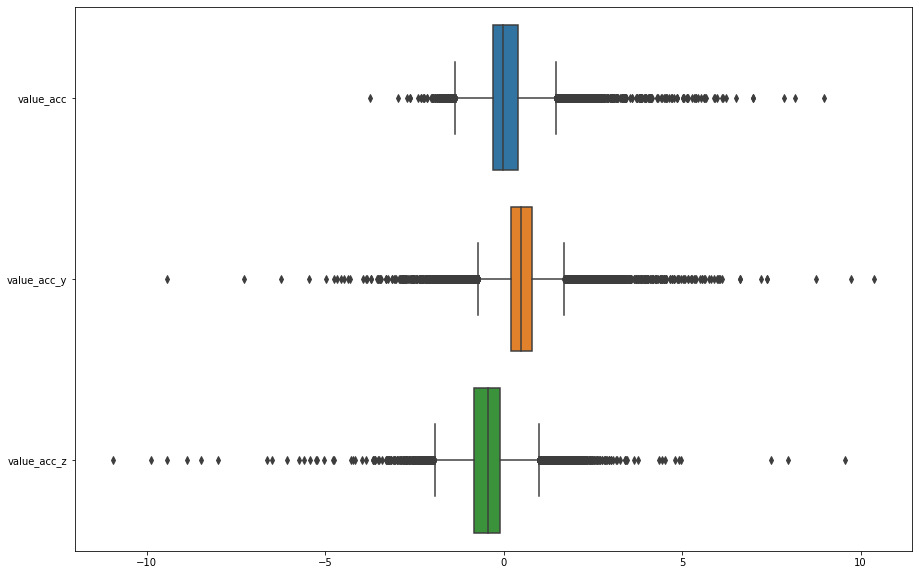

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=aceleraciones[["value_acc",'value_acc_y','value_acc_z']],orient='h')
display(ax)

Observamos que hay ciertos outliers en nuestra muestra de datos, pero no tienen que porque ser errores de mediciones, ya que los numeros no son muy desorbitados para poder conlcluir esto. Estos outliers pueden deverse a alguna actividad física del usuario haya hecho de forma expontanea o algún movimento brusco con la mano. Mas adelante concluiremos si estos datos nos aportan valor o no, ya que lo  correlacionaremos con la frecuencia cardiaca.

In [7]:
#Calculamos los Jerks de cada eje y los respectivos módulos
aceleraciones['jerk_x'] = aceleraciones['value_acc']-aceleraciones['value_acc'].shift()
aceleraciones['jerk_y'] = aceleraciones['value_acc_y']-aceleraciones['value_acc_y'].shift()
aceleraciones['jerk_z'] = aceleraciones['value_acc_z']-aceleraciones['value_acc_z'].shift()
aceleraciones['modulo'] = (aceleraciones["value_acc"]**2+aceleraciones["value_acc_y"]**2+aceleraciones["value_acc_z"]**2)**0.5
aceleraciones['modulo_jerk'] = (aceleraciones["jerk_x"]**2+aceleraciones["jerk_y"]**2+aceleraciones["jerk_z"]**2)**0.5

In [8]:
aceleraciones.head()

,id_,value_acc,value_acc_y,value_acc_z,jerk_x,jerk_y,jerk_z,modulo,modulo_jerk
0,0,-0.837891,0.300049,-0.437500,NaN,NaN,NaN,0.991714,NaN
1,0,-0.850586,0.297119,-0.448242,-0.012695,-0.002930,-0.010742,1.006329,0.016886
2,0,-0.835449,0.309814,-0.450928,0.015137,0.012695,-0.002686,0.998647,0.019937
3,0,-0.839844,0.322021,-0.442383,-0.004395,0.012207,0.008545,1.002366,0.015535
4,0,-0.842285,0.277344,-0.418945,-0.002441,-0.044678,0.023438,0.980754,0.050511


### Frecuencia cardiaca

In [9]:
df = pd.read_csv('energy.csv')

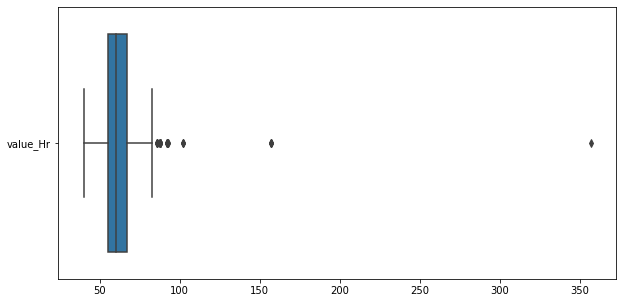

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax = sns.boxplot(data =df[["value_Hr"]],orient='h')
display(ax)

Aqui podemos ver nuestro primer outlier, obvimanete es debido a un error de médida ya que una persona no puede llegar a obtener una frecuencia cardiaca por encima de los 200 (vivo),  a no ser que le esté dando una taquicardia.
Para ello buscamos el  outlier y si es necesario eliminamos ese dato o lo arreglamos.

In [11]:
df[df.value_Hr>200]

,date_Hr,value_Hr,startDate_energy,endDate_energy,totalTime_energy,value_energy,id_
77,2020-03-30 16:46:36,357.0,2020-03-30 16:50:21,2020-03-30 16:51:23,62.0,0.363,77


In [12]:
df[76:79]

,date_Hr,value_Hr,startDate_energy,endDate_energy,totalTime_energy,value_energy,id_
76,2020-03-30 16:46:36,63.0,2020-03-30 16:49:19,2020-03-30 16:50:21,62.0,0.364,76
77,2020-03-30 16:46:36,357.0,2020-03-30 16:50:21,2020-03-30 16:51:23,62.0,0.363,77
78,2020-03-30 16:46:36,63.0,2020-03-30 16:51:23,2020-03-30 16:52:25,62.0,0.317,78


Concluimos que es un error de medida por ello lo sustituimos por el valor tomado en el mismo momento.

In [13]:
df.iloc[77,1] = 63

### Energia

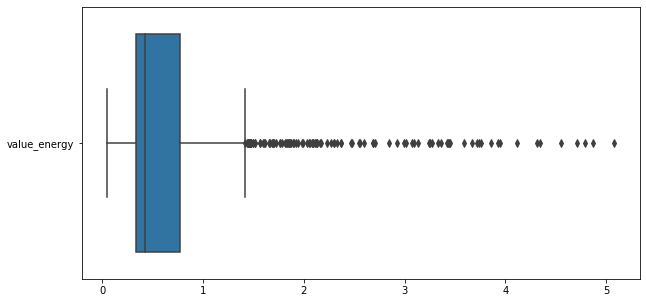

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax = sns.boxplot(data =df[["value_energy"]],orient='h')
display(ax)

Como hablamos anteriormente estos outliers pueden suponerse a ejercicios físicos en un determinado momento del dia

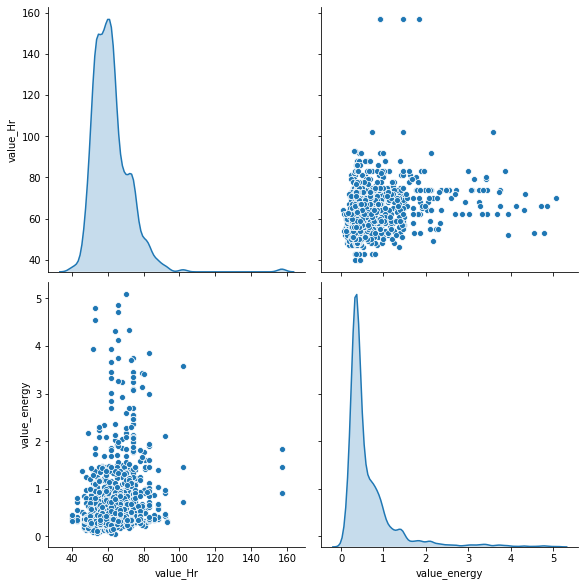

In [15]:
sns.pairplot(df[['value_Hr', 'value_energy']], kind="scatter", diag_kind= 'kde',height=4)

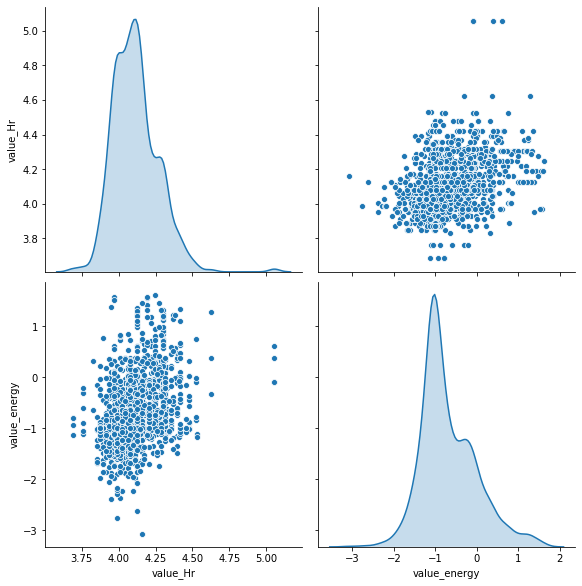

In [16]:
import numpy as np
#Esta trasnformación logaritmica ayudará a nuestro algoritmo a afinar su precisión.
sns.pairplot(np.log(df[['value_Hr', 'value_energy']]), kind="scatter", diag_kind= 'kde',height=4)

## Tratamiento de los datos

In [17]:
#Unimos los datos en un mismo dataframe, cogemos hasta el Id = 1400 en aceleraciones porque es hasta donde tenemos en el otro data set
df = aceleraciones[aceleraciones.id_<1401].merge(df, on='id_',how= 'left')

In [18]:
#Convertimos la variable startDate_energy en formato date time y posteriormente añadimos varibales de tiempo
#Es importante destacar que el minuto en estos casos puede hacer que nuestro algorimo sesgue el entrenamiento debido a la poca cantidad de tramos
df['startDate_energy'] = pd.to_datetime(df['startDate_energy'], format='%Y-%m-%d %H:%M:%S')

In [19]:
df.head()

,id_,value_acc,value_acc_y,value_acc_z,jerk_x,jerk_y,jerk_z,modulo,modulo_jerk,date_Hr,value_Hr,startDate_energy,endDate_energy,totalTime_energy,value_energy
0,0,-0.837891,0.300049,-0.437500,NaN,NaN,NaN,0.991714,NaN,2020-03-30 12:45:36,53.0,2020-03-30 12:44:59,2020-03-30 12:46:01,62.0,0.317
1,0,-0.850586,0.297119,-0.448242,-0.012695,-0.002930,-0.010742,1.006329,0.016886,2020-03-30 12:45:36,53.0,2020-03-30 12:44:59,2020-03-30 12:46:01,62.0,0.317
2,0,-0.835449,0.309814,-0.450928,0.015137,0.012695,-0.002686,0.998647,0.019937,2020-03-30 12:45:36,53.0,2020-03-30 12:44:59,2020-03-30 12:46:01,62.0,0.317
3,0,-0.839844,0.322021,-0.442383,-0.004395,0.012207,0.008545,1.002366,0.015535,2020-03-30 12:45:36,53.0,2020-03-30 12:44:59,2020-03-30 12:46:01,62.0,0.317
4,0,-0.842285,0.277344,-0.418945,-0.002441,-0.044678,0.023438,0.980754,0.050511,2020-03-30 12:45:36,53.0,2020-03-30 12:44:59,2020-03-30 12:46:01,62.0,0.317


In [20]:
#Eliminamos variables que creemos que no aportan significado.
df= df.drop(['date_Hr','endDate_energy','startDate_energy','totalTime_energy'],axis=1)

In [21]:
import numpy as np
#Transformamos value_energy y value_Hr en una función logaritmica.
df = np.log(df[['value_Hr', 'value_energy']]).join(df.drop(['value_Hr', 'value_energy'],axis=1))

In [22]:
df

,value_Hr,value_energy,id_,value_acc,value_acc_y,value_acc_z,jerk_x,jerk_y,jerk_z,modulo,modulo_jerk
0,3.970292,-1.148854,0,-0.837891,0.300049,-0.437500,NaN,NaN,NaN,0.991714,NaN
1,3.970292,-1.148854,0,-0.850586,0.297119,-0.448242,-0.012695,-0.002930,-0.010742,1.006329,0.016886
2,3.970292,-1.148854,0,-0.835449,0.309814,-0.450928,0.015137,0.012695,-0.002686,0.998647,0.019937
3,3.970292,-1.148854,0,-0.839844,0.322021,-0.442383,-0.004395,0.012207,0.008545,1.002366,0.015535
4,3.970292,-1.148854,0,-0.842285,0.277344,-0.418945,-0.002441,-0.044678,0.023438,0.980754,0.050511
...,...,...,...,...,...,...,...,...,...,...,...
1458436,4.142353,-1.838851,1400,-0.775803,0.319290,-0.538345,-0.001617,-0.006592,-0.001297,0.996811,0.006910
1458437,4.142353,-1.838851,1400,-0.774475,0.321259,-0.535660,0.001328,0.001968,0.002686,0.994962,0.003585
1458438,4.142353,-1.838851,1400,-0.776825,0.324936,-0.536438,-0.002350,0.003677,-0.000778,0.998402,0.004433
1458439,4.142353,-1.838851,1400,-0.777145,0.325150,-0.533646,-0.000320,0.000214,0.002792,0.997224,0.002819


In [23]:
#Haremos el estudio de algunas posibles conbinaciones lineales aleatoreas para buscar mas infromación en nuestro data set.
df_feature = df.drop('value_energy',axis=1).fillna(0)
target = df['value_energy']

from autofeat import FeatureSelector, AutoFeatRegressor
for steps in range(2):
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(df_feature, target)
    r2 = afreg.score(df_feature, target)
    print("## Final R^2: %.4f" % r2)

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 10 features.
[AutoFeat] With 1458441 data points this new feature matrix would use about 0.06 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 10 features after 5 feature selection runs
[featsel] 10 features after correlation filtering
[featsel] 10 features after noise filtering
[AutoFeat] Final dataframe with 10 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
-3.9118104969281866
0.841585 * value_Hr
0.518292 * modulo_jerk
0.479947 * value_acc
-0.259444 * modulo
0.223013 * value_acc_z
-0.127721 * jerk_x
-0.113050 * jerk_z
0.020218 * jerk_y
0.015755 * value_acc_y
0.000036 * id

In [24]:
df['value_energy']= target.reset_index()['value_energy']

In [2]:
df.columns

/Users/alexisjimenez/opt/anaconda3/envs/xgboost/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['value_Hr', 'id_', 'value_acc', 'value_acc_y', 'value_acc_z', 'jerk_x',
       'jerk_y', 'jerk_z', 'modulo', 'modulo_jerk', '1/modulo', 'Abs(jerk_y)',
       'Abs(jerk_z)', 'value_acc**3', 'Abs(value_acc)', 'value_acc_y**2',
       'Abs(value_acc_y)', 'sqrt(modulo_jerk)', 'Abs(value_acc_z)',
       'value_energy'],
      dtype='object')

In [3]:
df=df.rename(columns={'1/modulo': '1_modulo','value_acc**3':'value_acc3','value_acc_y**2':'value_acc_y_2'})


In [4]:
df.columns

Index(['value_Hr', 'id_', 'value_acc', 'value_acc_y', 'value_acc_z', 'jerk_x',
       'jerk_y', 'jerk_z', 'modulo', 'modulo_jerk', '1_modulo', 'Abs(jerk_y)',
       'Abs(jerk_z)', 'value_acc3', 'Abs(value_acc)', 'value_acc_y_2',
       'Abs(value_acc_y)', 'sqrt(modulo_jerk)', 'Abs(value_acc_z)',
       'value_energy'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop(['id_','value_energy'],axis =1), df['value_energy'], test_size=0.33, random_state=42)

## GridSearch 

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb1 = XGBRegressor()
parameters = { 
                      'objective':['reg:linear'],
                      'learning_rate': [0.05,0.08,0.1,0.2], 
                      'max_depth': [2,4,5],
                      'min_child_weight': [30,50,70,80],
                      'silent': [1],
                      'subsample': [0.2,0.5,0.55,0.6,0.8],
                      'colsample_bytree': [0.7,0.8,0.5],
                      'n_estimators': [150]}

xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            scoring='neg_mean_squared_error', 
                            cv = 7,
                            n_jobs = 4,
                            verbose=True)


grid_result = xgb_grid.fit(train_x[:10000],train_y[:10000])

Fitting 7 folds for each of 720 candidates, totalling 5040 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 15.9min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 19.1min
[Parallel(n_jobs=4)]: Done 5040 out of 5040 | elapsed: 19.4min finished


In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.240520 using {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 150, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.8}


In [28]:
import numpy as np
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels))))

## Algoritmo XGBoost

In [29]:
from xgboost import XGBRegressor
#Xgboost tiene una funcion para poder medir el error en el entrenamiento, pero en mi ordenador no la tengo disponible, para ello hemos creado nuestra propia función de error.
# eval_metric='mape'
model = XGBRegressor(objective ='reg:squarederror',
    max_depth=5,
    n_estimators=1000,
    min_child_weight=30, 
    colsample_bytree=0.5,
    learning_rate = 0.05,
    subsample=0.8,
    silent =1,
    eta=0.7,    
    seed=60)

model.fit(
    train_x, 
    train_y, 
    eval_metric=xgb_mape, 
    eval_set=[(train_x, train_y),(test_x, test_y)], 
    verbose=True)

[0]	validation_0-rmse:1.30317	validation_1-rmse:1.30430	validation_0-mape:2.94571	validation_1-mape:2.93736
[1]	validation_0-rmse:1.24833	validation_1-rmse:1.24942	validation_0-mape:2.71747	validation_1-mape:2.70819
[2]	validation_0-rmse:1.19886	validation_1-rmse:1.20000	validation_0-mape:2.49434	validation_1-mape:2.48635
[3]	validation_0-rmse:1.15233	validation_1-rmse:1.15351	validation_0-mape:2.28545	validation_1-mape:2.27835
[4]	validation_0-rmse:1.10676	validation_1-rmse:1.10795	validation_0-mape:2.09978	validation_1-mape:2.09209
[5]	validation_0-rmse:1.06549	validation_1-rmse:1.06671	validation_0-mape:1.91681	validation_1-mape:1.90909
[6]	validation_0-rmse:1.02611	validation_1-rmse:1.02736	validation_0-mape:1.74146	validation_1-mape:1.73453
[7]	validation_0-rmse:0.98763	validation_1-rmse:0.98889	validation_0-mape:1.60101	validation_1-mape:1.59372
[8]	validation_0-rmse:0.95212	validation_1-rmse:0.95342	validation_0-mape:1.48641	validation_1-mape:1.47938
[9]	validation_0-rmse:0.9182

[76]	validation_0-rmse:0.48342	validation_1-rmse:0.48558	validation_0-mape:2.06819	validation_1-mape:2.08759
[77]	validation_0-rmse:0.48284	validation_1-rmse:0.48501	validation_0-mape:2.06955	validation_1-mape:2.08832
[78]	validation_0-rmse:0.48230	validation_1-rmse:0.48449	validation_0-mape:2.07261	validation_1-mape:2.09142
[79]	validation_0-rmse:0.48186	validation_1-rmse:0.48405	validation_0-mape:2.07544	validation_1-mape:2.09435
[80]	validation_0-rmse:0.48170	validation_1-rmse:0.48390	validation_0-mape:2.07677	validation_1-mape:2.09586
[81]	validation_0-rmse:0.48122	validation_1-rmse:0.48341	validation_0-mape:2.07981	validation_1-mape:2.09899
[82]	validation_0-rmse:0.48104	validation_1-rmse:0.48324	validation_0-mape:2.08142	validation_1-mape:2.10074
[83]	validation_0-rmse:0.48065	validation_1-rmse:0.48285	validation_0-mape:2.08527	validation_1-mape:2.10463
[84]	validation_0-rmse:0.48054	validation_1-rmse:0.48274	validation_0-mape:2.08676	validation_1-mape:2.10617
[85]	validation_0-r

[151]	validation_0-rmse:0.46967	validation_1-rmse:0.47217	validation_0-mape:2.11205	validation_1-mape:2.13353
[152]	validation_0-rmse:0.46946	validation_1-rmse:0.47196	validation_0-mape:2.11155	validation_1-mape:2.13305
[153]	validation_0-rmse:0.46926	validation_1-rmse:0.47177	validation_0-mape:2.11216	validation_1-mape:2.13389
[154]	validation_0-rmse:0.46923	validation_1-rmse:0.47175	validation_0-mape:2.11216	validation_1-mape:2.13381
[155]	validation_0-rmse:0.46905	validation_1-rmse:0.47158	validation_0-mape:2.11237	validation_1-mape:2.13398
[156]	validation_0-rmse:0.46881	validation_1-rmse:0.47135	validation_0-mape:2.11299	validation_1-mape:2.13489
[157]	validation_0-rmse:0.46865	validation_1-rmse:0.47118	validation_0-mape:2.11092	validation_1-mape:2.13245
[158]	validation_0-rmse:0.46855	validation_1-rmse:0.47110	validation_0-mape:2.11013	validation_1-mape:2.13175
[159]	validation_0-rmse:0.46846	validation_1-rmse:0.47102	validation_0-mape:2.10920	validation_1-mape:2.13070
[160]	vali

[226]	validation_0-rmse:0.46299	validation_1-rmse:0.46591	validation_0-mape:2.09525	validation_1-mape:2.11566
[227]	validation_0-rmse:0.46289	validation_1-rmse:0.46582	validation_0-mape:2.09541	validation_1-mape:2.11591
[228]	validation_0-rmse:0.46279	validation_1-rmse:0.46573	validation_0-mape:2.09534	validation_1-mape:2.11586
[229]	validation_0-rmse:0.46278	validation_1-rmse:0.46572	validation_0-mape:2.09520	validation_1-mape:2.11571
[230]	validation_0-rmse:0.46274	validation_1-rmse:0.46569	validation_0-mape:2.09515	validation_1-mape:2.11565
[231]	validation_0-rmse:0.46271	validation_1-rmse:0.46565	validation_0-mape:2.09538	validation_1-mape:2.11590
[232]	validation_0-rmse:0.46266	validation_1-rmse:0.46561	validation_0-mape:2.09511	validation_1-mape:2.11569
[233]	validation_0-rmse:0.46258	validation_1-rmse:0.46554	validation_0-mape:2.09472	validation_1-mape:2.11529
[234]	validation_0-rmse:0.46244	validation_1-rmse:0.46541	validation_0-mape:2.09474	validation_1-mape:2.11533
[235]	vali

[301]	validation_0-rmse:0.45853	validation_1-rmse:0.46180	validation_0-mape:2.08304	validation_1-mape:2.10399
[302]	validation_0-rmse:0.45851	validation_1-rmse:0.46177	validation_0-mape:2.08302	validation_1-mape:2.10400
[303]	validation_0-rmse:0.45843	validation_1-rmse:0.46171	validation_0-mape:2.08274	validation_1-mape:2.10384
[304]	validation_0-rmse:0.45841	validation_1-rmse:0.46169	validation_0-mape:2.08261	validation_1-mape:2.10376
[305]	validation_0-rmse:0.45839	validation_1-rmse:0.46168	validation_0-mape:2.08260	validation_1-mape:2.10377
[306]	validation_0-rmse:0.45837	validation_1-rmse:0.46167	validation_0-mape:2.08247	validation_1-mape:2.10363
[307]	validation_0-rmse:0.45837	validation_1-rmse:0.46167	validation_0-mape:2.08251	validation_1-mape:2.10363
[308]	validation_0-rmse:0.45835	validation_1-rmse:0.46166	validation_0-mape:2.08249	validation_1-mape:2.10358
[309]	validation_0-rmse:0.45832	validation_1-rmse:0.46163	validation_0-mape:2.08241	validation_1-mape:2.10352
[310]	vali

[376]	validation_0-rmse:0.45472	validation_1-rmse:0.45829	validation_0-mape:2.07076	validation_1-mape:2.09175
[377]	validation_0-rmse:0.45463	validation_1-rmse:0.45821	validation_0-mape:2.06935	validation_1-mape:2.09027
[378]	validation_0-rmse:0.45460	validation_1-rmse:0.45817	validation_0-mape:2.06932	validation_1-mape:2.09023
[379]	validation_0-rmse:0.45452	validation_1-rmse:0.45810	validation_0-mape:2.06913	validation_1-mape:2.09006
[380]	validation_0-rmse:0.45449	validation_1-rmse:0.45809	validation_0-mape:2.06922	validation_1-mape:2.09017
[381]	validation_0-rmse:0.45447	validation_1-rmse:0.45806	validation_0-mape:2.06893	validation_1-mape:2.08986
[382]	validation_0-rmse:0.45445	validation_1-rmse:0.45805	validation_0-mape:2.06865	validation_1-mape:2.08957
[383]	validation_0-rmse:0.45444	validation_1-rmse:0.45804	validation_0-mape:2.06851	validation_1-mape:2.08943
[384]	validation_0-rmse:0.45443	validation_1-rmse:0.45803	validation_0-mape:2.06842	validation_1-mape:2.08940
[385]	vali

[451]	validation_0-rmse:0.45226	validation_1-rmse:0.45611	validation_0-mape:2.05943	validation_1-mape:2.08104
[452]	validation_0-rmse:0.45216	validation_1-rmse:0.45601	validation_0-mape:2.05959	validation_1-mape:2.08115
[453]	validation_0-rmse:0.45215	validation_1-rmse:0.45601	validation_0-mape:2.05965	validation_1-mape:2.08122
[454]	validation_0-rmse:0.45214	validation_1-rmse:0.45599	validation_0-mape:2.05958	validation_1-mape:2.08114
[455]	validation_0-rmse:0.45213	validation_1-rmse:0.45599	validation_0-mape:2.05956	validation_1-mape:2.08114
[456]	validation_0-rmse:0.45213	validation_1-rmse:0.45599	validation_0-mape:2.05943	validation_1-mape:2.08100
[457]	validation_0-rmse:0.45211	validation_1-rmse:0.45598	validation_0-mape:2.05927	validation_1-mape:2.08082
[458]	validation_0-rmse:0.45206	validation_1-rmse:0.45593	validation_0-mape:2.05880	validation_1-mape:2.08022
[459]	validation_0-rmse:0.45204	validation_1-rmse:0.45591	validation_0-mape:2.05908	validation_1-mape:2.08056
[460]	vali

[526]	validation_0-rmse:0.45023	validation_1-rmse:0.45435	validation_0-mape:2.05257	validation_1-mape:2.07369
[527]	validation_0-rmse:0.45022	validation_1-rmse:0.45435	validation_0-mape:2.05251	validation_1-mape:2.07367
[528]	validation_0-rmse:0.45021	validation_1-rmse:0.45435	validation_0-mape:2.05254	validation_1-mape:2.07368
[529]	validation_0-rmse:0.45019	validation_1-rmse:0.45432	validation_0-mape:2.05241	validation_1-mape:2.07352
[530]	validation_0-rmse:0.45014	validation_1-rmse:0.45428	validation_0-mape:2.05232	validation_1-mape:2.07341
[531]	validation_0-rmse:0.45010	validation_1-rmse:0.45425	validation_0-mape:2.05249	validation_1-mape:2.07361
[532]	validation_0-rmse:0.45009	validation_1-rmse:0.45424	validation_0-mape:2.05239	validation_1-mape:2.07349
[533]	validation_0-rmse:0.45008	validation_1-rmse:0.45423	validation_0-mape:2.05223	validation_1-mape:2.07332
[534]	validation_0-rmse:0.45007	validation_1-rmse:0.45422	validation_0-mape:2.05213	validation_1-mape:2.07321
[535]	vali

[601]	validation_0-rmse:0.44819	validation_1-rmse:0.45266	validation_0-mape:2.04435	validation_1-mape:2.06610
[602]	validation_0-rmse:0.44818	validation_1-rmse:0.45265	validation_0-mape:2.04432	validation_1-mape:2.06610
[603]	validation_0-rmse:0.44817	validation_1-rmse:0.45264	validation_0-mape:2.04440	validation_1-mape:2.06616
[604]	validation_0-rmse:0.44816	validation_1-rmse:0.45264	validation_0-mape:2.04435	validation_1-mape:2.06617
[605]	validation_0-rmse:0.44816	validation_1-rmse:0.45264	validation_0-mape:2.04432	validation_1-mape:2.06612
[606]	validation_0-rmse:0.44816	validation_1-rmse:0.45264	validation_0-mape:2.04432	validation_1-mape:2.06614
[607]	validation_0-rmse:0.44812	validation_1-rmse:0.45260	validation_0-mape:2.04376	validation_1-mape:2.06563
[608]	validation_0-rmse:0.44810	validation_1-rmse:0.45259	validation_0-mape:2.04345	validation_1-mape:2.06535
[609]	validation_0-rmse:0.44809	validation_1-rmse:0.45259	validation_0-mape:2.04341	validation_1-mape:2.06533
[610]	vali

[676]	validation_0-rmse:0.44643	validation_1-rmse:0.45118	validation_0-mape:2.03705	validation_1-mape:2.05915
[677]	validation_0-rmse:0.44643	validation_1-rmse:0.45118	validation_0-mape:2.03709	validation_1-mape:2.05922
[678]	validation_0-rmse:0.44637	validation_1-rmse:0.45112	validation_0-mape:2.03721	validation_1-mape:2.05927
[679]	validation_0-rmse:0.44629	validation_1-rmse:0.45105	validation_0-mape:2.03691	validation_1-mape:2.05905
[680]	validation_0-rmse:0.44628	validation_1-rmse:0.45105	validation_0-mape:2.03693	validation_1-mape:2.05909
[681]	validation_0-rmse:0.44627	validation_1-rmse:0.45104	validation_0-mape:2.03686	validation_1-mape:2.05907
[682]	validation_0-rmse:0.44627	validation_1-rmse:0.45104	validation_0-mape:2.03686	validation_1-mape:2.05907
[683]	validation_0-rmse:0.44625	validation_1-rmse:0.45103	validation_0-mape:2.03681	validation_1-mape:2.05908
[684]	validation_0-rmse:0.44623	validation_1-rmse:0.45101	validation_0-mape:2.03690	validation_1-mape:2.05916
[685]	vali

[751]	validation_0-rmse:0.44466	validation_1-rmse:0.44969	validation_0-mape:2.02792	validation_1-mape:2.05075
[752]	validation_0-rmse:0.44466	validation_1-rmse:0.44969	validation_0-mape:2.02783	validation_1-mape:2.05065
[753]	validation_0-rmse:0.44466	validation_1-rmse:0.44968	validation_0-mape:2.02777	validation_1-mape:2.05059
[754]	validation_0-rmse:0.44465	validation_1-rmse:0.44968	validation_0-mape:2.02780	validation_1-mape:2.05062
[755]	validation_0-rmse:0.44465	validation_1-rmse:0.44968	validation_0-mape:2.02782	validation_1-mape:2.05065
[756]	validation_0-rmse:0.44460	validation_1-rmse:0.44964	validation_0-mape:2.02728	validation_1-mape:2.05012
[757]	validation_0-rmse:0.44459	validation_1-rmse:0.44963	validation_0-mape:2.02733	validation_1-mape:2.05020
[758]	validation_0-rmse:0.44459	validation_1-rmse:0.44963	validation_0-mape:2.02733	validation_1-mape:2.05018
[759]	validation_0-rmse:0.44458	validation_1-rmse:0.44963	validation_0-mape:2.02729	validation_1-mape:2.05015
[760]	vali

[826]	validation_0-rmse:0.44323	validation_1-rmse:0.44852	validation_0-mape:2.02351	validation_1-mape:2.04693
[827]	validation_0-rmse:0.44316	validation_1-rmse:0.44846	validation_0-mape:2.02338	validation_1-mape:2.04672
[828]	validation_0-rmse:0.44312	validation_1-rmse:0.44842	validation_0-mape:2.02334	validation_1-mape:2.04672
[829]	validation_0-rmse:0.44312	validation_1-rmse:0.44842	validation_0-mape:2.02331	validation_1-mape:2.04668
[830]	validation_0-rmse:0.44309	validation_1-rmse:0.44838	validation_0-mape:2.02305	validation_1-mape:2.04636
[831]	validation_0-rmse:0.44302	validation_1-rmse:0.44833	validation_0-mape:2.02280	validation_1-mape:2.04609
[832]	validation_0-rmse:0.44302	validation_1-rmse:0.44833	validation_0-mape:2.02278	validation_1-mape:2.04609
[833]	validation_0-rmse:0.44302	validation_1-rmse:0.44833	validation_0-mape:2.02278	validation_1-mape:2.04611
[834]	validation_0-rmse:0.44301	validation_1-rmse:0.44833	validation_0-mape:2.02284	validation_1-mape:2.04617
[835]	vali

[901]	validation_0-rmse:0.44181	validation_1-rmse:0.44739	validation_0-mape:2.01820	validation_1-mape:2.04237
[902]	validation_0-rmse:0.44181	validation_1-rmse:0.44739	validation_0-mape:2.01816	validation_1-mape:2.04235
[903]	validation_0-rmse:0.44178	validation_1-rmse:0.44737	validation_0-mape:2.01816	validation_1-mape:2.04239
[904]	validation_0-rmse:0.44175	validation_1-rmse:0.44734	validation_0-mape:2.01835	validation_1-mape:2.04258
[905]	validation_0-rmse:0.44174	validation_1-rmse:0.44734	validation_0-mape:2.01837	validation_1-mape:2.04259
[906]	validation_0-rmse:0.44169	validation_1-rmse:0.44728	validation_0-mape:2.01839	validation_1-mape:2.04262
[907]	validation_0-rmse:0.44169	validation_1-rmse:0.44728	validation_0-mape:2.01836	validation_1-mape:2.04260
[908]	validation_0-rmse:0.44168	validation_1-rmse:0.44728	validation_0-mape:2.01824	validation_1-mape:2.04246
[909]	validation_0-rmse:0.44167	validation_1-rmse:0.44728	validation_0-mape:2.01818	validation_1-mape:2.04238
[910]	vali

[976]	validation_0-rmse:0.44078	validation_1-rmse:0.44665	validation_0-mape:2.01560	validation_1-mape:2.04011
[977]	validation_0-rmse:0.44078	validation_1-rmse:0.44665	validation_0-mape:2.01557	validation_1-mape:2.04010
[978]	validation_0-rmse:0.44077	validation_1-rmse:0.44664	validation_0-mape:2.01555	validation_1-mape:2.04007
[979]	validation_0-rmse:0.44076	validation_1-rmse:0.44663	validation_0-mape:2.01548	validation_1-mape:2.04004
[980]	validation_0-rmse:0.44076	validation_1-rmse:0.44663	validation_0-mape:2.01554	validation_1-mape:2.04009
[981]	validation_0-rmse:0.44074	validation_1-rmse:0.44663	validation_0-mape:2.01540	validation_1-mape:2.03994
[982]	validation_0-rmse:0.44074	validation_1-rmse:0.44663	validation_0-mape:2.01537	validation_1-mape:2.03997
[983]	validation_0-rmse:0.44072	validation_1-rmse:0.44661	validation_0-mape:2.01530	validation_1-mape:2.03990
[984]	validation_0-rmse:0.44067	validation_1-rmse:0.44657	validation_0-mape:2.01537	validation_1-mape:2.03993
[985]	vali

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.7, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=30, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=60,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=60, silent=1,
             subsample=0.8, tree_method=None, validate_parameters=False,
             verbosity=None)

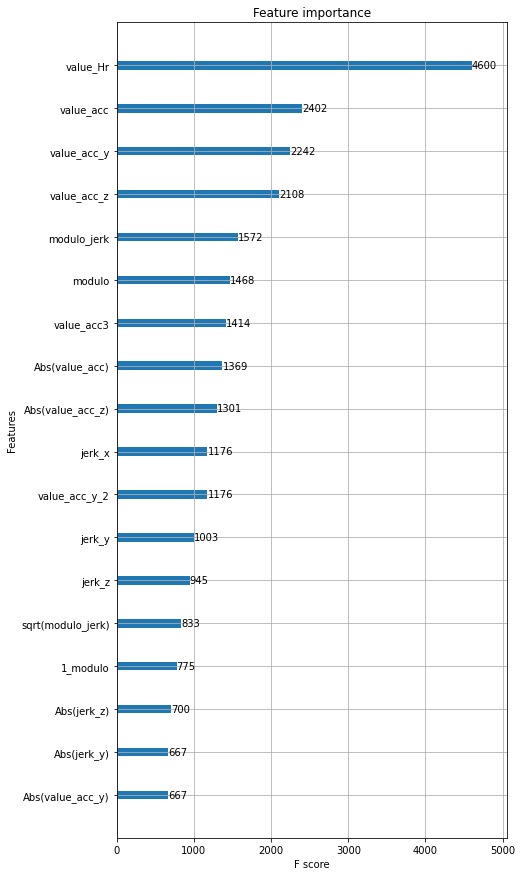

In [79]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(7,15))
plot_importance(model, ax=ax)

In [30]:
#Desacemos la expresión logaritmica y lo unimos al dataframe
preds_train_log_x = model.predict(train_x)
preds_test_log_x = model.predict(test_x)
preds_train = np.exp(preds_train_log_x)
preds_test = np.exp(preds_test_log_x)
train_y_ = np.exp(train_y)
test_y_ =np.exp(test_y)

train_x['preds_log'] = preds_train_log_x
train_x['preds'] = preds_train
train_x['value_energy']=train_y_

test_x['preds_log'] = preds_test_log_x
test_x['preds'] = preds_test
test_x['value_energy']=test_y_

train = train_x.join(df[['id_']])
test = test_x.join(df[['id_']])

In [31]:
test

,value_Hr,value_acc,value_acc_y,value_acc_z,jerk_x,jerk_y,jerk_z,modulo,modulo_jerk,1_modulo,...,value_acc3,Abs(value_acc),value_acc_y_2,Abs(value_acc_y),sqrt(modulo_jerk),Abs(value_acc_z),preds_log,preds,value_energy,id_
583682,4.174387,0.987793,-0.238770,-0.301025,0.035889,0.058350,-0.065430,1.059888,0.094730,0.943496,...,0.963824,0.987793,0.057011,0.238770,0.307782,0.301025,-0.126239,0.881404,1.919,560.0
151493,3.970292,-0.199951,0.116699,-0.994629,-0.092529,0.071045,-0.026123,1.021218,0.119547,0.979223,...,-0.007994,0.199951,0.013619,0.116699,0.345756,0.994629,-1.065384,0.344595,0.332,145.0
1193393,4.110874,0.352295,0.828613,0.330078,-0.055664,-0.011719,-0.016602,0.958991,0.059257,1.042763,...,0.043724,0.352295,0.686600,0.828613,0.243428,0.330078,-0.551821,0.575900,0.504,1146.0
29969,4.060443,-0.105957,0.653809,-0.757812,0.007080,0.022217,0.005615,1.006465,0.023984,0.993576,...,-0.001190,0.105957,0.427466,0.653809,0.154869,0.757812,-1.067077,0.344012,0.316,28.0
1152789,4.060443,-0.116455,0.960205,0.246826,-0.146729,0.155273,0.115479,0.998238,0.242846,1.001765,...,-0.001579,0.116455,0.921994,0.960205,0.492795,0.246826,-0.559116,0.571714,0.352,1107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649939,4.174387,0.783615,0.155243,-0.642807,-0.113785,-0.209686,0.100159,1.025355,0.258741,0.975272,...,0.481181,0.783615,0.024100,0.155243,0.508666,0.642807,-0.127802,0.880028,0.475,624.0
546955,3.970292,-0.322021,0.814453,-0.391602,0.026611,-0.037109,-0.056396,0.959366,0.072566,1.042355,...,-0.033393,0.322021,0.663334,0.814453,0.269381,0.391602,-0.666553,0.513476,0.335,525.0
1044594,4.143135,0.221283,0.639435,-0.740768,-0.007614,0.000198,-0.000107,1.003285,0.007617,0.996726,...,0.010835,0.221283,0.408877,0.639435,0.087278,0.740768,-0.929941,0.394577,0.703,1003.0
1409781,3.912023,-0.082642,0.454163,-0.893936,-0.000732,0.004623,-0.000488,1.006089,0.004706,0.993948,...,-0.000564,0.082642,0.206264,0.454163,0.068604,0.893936,-1.304129,0.271409,0.237,1354.0


## Analisis de respuesta

Miraremos que respuesta es la mejor para cada intervalo de tiempo generado

In [32]:
group =test.groupby('id_').agg({'preds': ['min', 'max','mean'],'value_energy': ['min', 'max','mean']})


In [33]:
group.columns = ['pred_min','pred_max','pred_mean','value_min','value_max','value_mean']
group.reset_index(inplace=True)
group

,id_,pred_min,pred_max,pred_mean,value_min,value_max,value_mean
0,0.0,0.285629,0.532009,0.329901,0.317,0.317,0.317
1,1.0,0.275444,1.045283,0.607723,0.335,0.335,0.335
2,2.0,0.209388,1.038177,0.360087,0.276,0.276,0.276
3,3.0,0.294498,0.628997,0.354899,0.648,0.648,0.648
4,4.0,0.232655,0.754197,0.282151,0.263,0.263,0.263
...,...,...,...,...,...,...,...
1396,1396.0,0.347869,0.985792,0.510688,0.546,0.546,0.546
1397,1397.0,0.355727,1.114554,0.557802,0.479,0.479,0.479
1398,1398.0,0.156118,0.624910,0.222842,0.126,0.126,0.126
1399,1399.0,0.184116,0.688589,0.251825,0.126,0.126,0.126


In [34]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))
print('MAPE Test Set min:',mape(group.pred_min,group.value_mean))
print('MAPE Test Set max:',mape(group.pred_max,group.value_mean))
print('MAPE Test Set mean:',mape(group.pred_mean,group.value_mean))

MAPE Test Set min: 0.8781030276911945
MAPE Test Set max: 0.45947520073334464
MAPE Test Set mean: 0.3116796253896576


Observamos que cuando mejor se comporta es haciendo la media de todas las predicciones para ese mismo 'id_'.
Vamos a revisar en que numeros hemos tenido nuestros mayores fallos.

In [39]:
group['delta'] =abs(group['pred_mean']-group['value_mean'])
group[['delta']].describe()

,delta
count,1401.000000
mean,0.216987
std,0.383757
min,0.000141
25%,0.042583
50%,0.097845
75%,0.210092
max,3.914536


La media de nuestro error esde 0.21 Kcal/min teniendo el error minimo de 0.000141 Kcal/min y un error maximo 3.91 kcal/min. Segun los percentiles de la información de la funcíon describe() nos da a suponer que el error  maximo que hemos tenido afecta mucho a la medida  de error MAPE

In [72]:
group[group.delta>1][['pred_mean','value_mean','delta']].describe()

,pred_mean,value_mean,delta
count,54.000000,54.000000,54.000000
mean,1.294685,3.066352,1.771667
std,0.549028,0.916733,0.722780
min,0.627547,1.695000,1.011704
25%,0.820977,2.242750,1.280581
50%,1.186180,3.083500,1.544060
75%,1.636875,3.702750,2.040363
max,2.819561,5.080000,3.914536


Con esto podemso observamos como en los valores mas altos es donde  mas fallamos, algo normal debido a que la poca cantidad de datos altos que teniamos.

In [60]:
group['intensidad'] = np.where((group.value_mean <=3.75),'Intensidad Baja','')
group['intensidad'] = np.where((group.value_mean >3.75)|(group.value_mean >=7.5),'Intensidad Media',group.intensidad)
group['intensidad'] = np.where((group.value_mean >7.5),'Intensidad Alta',group['intensidad'])

group['intensidad_pred'] = np.where((group.pred_mean <=3.75),'Intensidad Baja','')
group['intensidad_pred'] = np.where((group.pred_mean >3.75)&(group.pred_mean >=7.5),'Intensidad Media',group['intensidad_pred'])
group['intensidad_pred'] = np.where((group.pred_mean >7.5),'Intensidad Alta',group['intensidad_pred'])

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(group.intensidad, group.intensidad_pred, labels=["Intensidad Baja", "Intensidad Media", "Intensidad Alta"])

array([[1389,    0,    0],
       [  12,    0,    0],
       [   0,    0,    0]])

In [59]:
group[group.intensidad=='Intensidad Media']

,id_,pred_min,pred_max,pred_mean,value_min,value_max,value_mean,intensidad,intensidad_pred,delta
441,441.0,0.567865,2.063807,1.244276,4.340,4.340,4.340,Intensidad Media,Intensidad Baja,3.095724
582,582.0,0.642174,3.517953,1.695041,4.120,4.120,4.120,Intensidad Media,Intensidad Baja,2.424959
585,585.0,1.449759,4.790461,2.787579,4.715,4.715,4.715,Intensidad Media,Intensidad Baja,1.927421
586,586.0,1.564647,4.772179,2.819561,4.867,4.867,4.867,Intensidad Media,Intensidad Baja,2.047439
587,587.0,0.477458,3.510083,1.387223,3.754,3.754,3.754,Intensidad Media,Intensidad Baja,2.366777
600,600.0,0.698857,6.299821,2.177579,5.080,5.080,5.080,Intensidad Media,Intensidad Baja,2.902421
640,640.0,0.546431,3.274794,1.624745,3.858,3.858,3.858,Intensidad Media,Intensidad Baja,2.233255
652,652.0,0.621239,2.708511,1.379174,3.926,3.926,3.926,Intensidad Media,Intensidad Baja,2.546826
824,824.0,0.525343,1.658493,0.878464,4.793,4.793,4.793,Intensidad Media,Intensidad Baja,3.914536
825,825.0,0.300631,1.309928,0.777933,4.551,4.551,4.551,Intensidad Media,Intensidad Baja,3.773067


Nos damos cuenta que para valores altos, en este caso intensidad media, nuestro algoritmo no es muy fiable, a la hora de predecir datos altos, pero todo tiene su explicación y es debido a la poca cantidad de tramos  de tiempo en la que se ha superado este nivel.

In [69]:
print('Total numero de muestras superiores a tres: ',len(train[train.value_energy>3][['id_','value_energy']].drop_duplicates()))
train[train.value_energy>3][['id_','value_energy']].drop_duplicates().head(10)

Total numero de muestras superiores a tres:  29


,id_,value_energy
1302285,1250.0,4.313
606687,582.0,4.120
1423110,1367.0,3.943
609329,585.0,4.715
701922,674.0,3.429
611563,587.0,3.754
680070,653.0,3.666
610953,586.0,4.867
857873,824.0,4.793
648524,622.0,3.738


In [77]:
model.save_model('model.xgb')